<a href="https://colab.research.google.com/github/cdoyle78/AlbertaCovid/blob/main/Calgary_covid_ww.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import requests
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
import csv
import seaborn as sns
%matplotlib inline

In [2]:
#Download covid-19 case stats from AHS webpage into data frame.

Alberta_AHS_Covid_Stats_url = 'https://www.alberta.ca/data/stats/covid-19-alberta-statistics-data.csv'

response = requests.get(Alberta_AHS_Covid_Stats_url)
print(response.status_code)
print(response.headers['content-type'])

# See https://requests.readthedocs.io/en/master/
# See https://pandas.pydata.org/docs/user_guide/io.html#io-read-csv-table
from io import StringIO
data_df_1 = pd.read_csv(StringIO(response.text))
data_df_1.head(10)

200
application/octet-stream


,Unnamed: 0,Date reported,Alberta Health Services Zone,Gender,Age group,Case status,Case type
0,1,2021-04-21,Edmonton Zone,Male,30-39 years,Recovered,Confirmed
1,2,2021-05-17,North Zone,Male,10-19 years,Recovered,Confirmed
2,3,2020-12-13,Edmonton Zone,Male,5-9 years,Recovered,Confirmed
3,4,2021-05-11,Edmonton Zone,Male,60-69 years,Recovered,Confirmed
4,5,2021-12-25,Edmonton Zone,Male,30-39 years,Active,Confirmed
5,6,2021-01-30,Calgary Zone,Female,1-4 years,Recovered,Confirmed
6,7,2021-09-23,South Zone,Female,80+ years,Recovered,Confirmed
7,8,2021-01-20,Edmonton Zone,Female,Under 1 year,Recovered,Confirmed
8,9,2020-12-06,Central Zone,Female,10-19 years,Recovered,Confirmed
9,10,2021-08-18,Edmonton Zone,Female,60-69 years,Recovered,Confirmed


In [3]:
#Isolate just Calgary Zone cases

data_yyc = data_df_1.drop(data_df_1[data_df_1['Alberta Health Services Zone'] != 'Calgary Zone'].index)
data_yyc.tail()

,Unnamed: 0,Date reported,Alberta Health Services Zone,Gender,Age group,Case status,Case type
384098,384099,2022-01-04,Calgary Zone,Male,50-59 years,Active,Confirmed
384101,384102,2021-09-03,Calgary Zone,Female,50-59 years,Recovered,Confirmed
384110,384111,2021-12-29,Calgary Zone,Male,30-39 years,Active,Confirmed
384112,384113,2021-12-30,Calgary Zone,Male,20-29 years,Active,Confirmed
384115,384116,2022-01-04,Calgary Zone,Male,30-39 years,Active,Confirmed


In [4]:
#Rename columns, sort cases by date

data_yyc.drop('Unnamed: 0', axis = 1, inplace = True)
data_yyc.rename(columns = {'Date reported': 'Date', 'Alberta Health Services Zone':'Zone', 
                            'Gender':'Gender','Age group':'Age', 'Case status':'Status', 
                            'Case type':'Type'}, inplace = True)
data_yyc.sort_values('Date', inplace = True)

In [12]:
#Create new dataframe for the number of cases each day

dly_Cases = data_yyc.groupby('Date').count()
dly_Cases.rename(columns = {'Age': 'Cases'}, inplace = True)
dly_Cases.reset_index(inplace = True)
dly_Cases = dly_Cases[['Date','Cases']]

#Add column for 7 day moving average

dly_Cases['7MA'] = dly_Cases['Cases'].rolling(window = 7, center = True).mean()
dly_Cases.tail(20)



,Date,Cases,7MA
648,2021-12-16,338,299.714286
649,2021-12-17,353,343.000000
650,2021-12-18,415,427.285714
651,2021-12-19,366,521.142857
652,2021-12-20,459,624.571429
653,2021-12-21,809,797.571429
654,2021-12-22,908,863.000000
655,2021-12-23,1062,840.285714
656,2021-12-24,1564,851.000000
657,2021-12-25,873,934.285714


In [6]:
#Set 'Date' (datetime) column as index

dly_Cases.set_index(dly_Cases['Date'], inplace = True)
dly_Cases.drop('Date',axis = 1, inplace = True)

In [9]:
#Read waste water viral counts from CSV file into dataframe. 
covid_ww = pd.read_csv('covid_ww.csv')

#Rename columns as set data types
#Set 'Date' (datetime) column as index
covid_ww.drop('Unnamed: 1', axis = 1, inplace = True)
covid_ww['Average'] = covid_ww['Average'].astype(float)
covid_ww['Date']= pd.to_datetime(covid_ww['Date'])
covid_ww.set_index(covid_ww['Date'], inplace = True)
covid_ww.drop('Date', axis = 1, inplace = True)
covid_ww.tail()

,Average
Date,
2021-12-14,1.380000e+14
2021-12-15,1.320000e+14
2021-12-19,2.160000e+14
2021-12-26,9.060000e+14
2022-01-02,6.270000e+14


In [10]:
#Now that both dataframes have datetime indexes, merge dataframes with an outer join

dly_cases_ww = dly_Cases.join(covid_ww, how='outer')


In [15]:
#Drop most recent data point 
dly_cases_ww2 = dly_cases_ww.dropna()
dly_cases_ww2 = dly_cases_ww2.drop(dly_cases_ww2[-1:].index)

[Text(0, 0.5, 'SARS-CoV-2 RNA flux (copies/day)'),
 Text(0.5, 0, 'YYC Daily Cases 7 Day MA')]

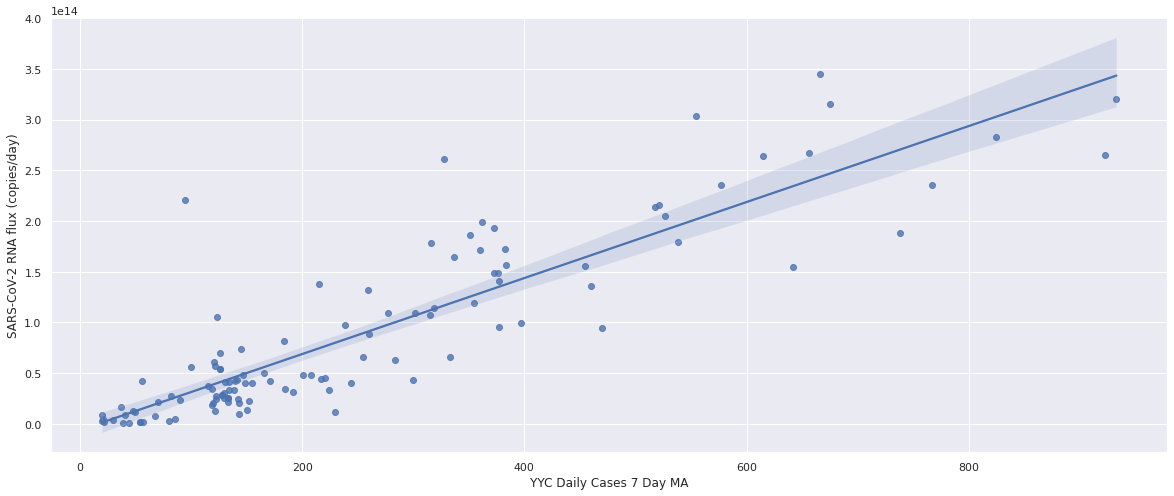

In [16]:
#Scatter plot to look at relationship between cases and viral counts in waste water.

sns.set(rc = {'figure.figsize':(20,8)})
#sns.set_style("darkgrid")
ax = sns.regplot(data = dly_cases_ww2, x = '7MA', y = 'Average')
ax.set(ylabel="SARS-CoV-2 RNA flux (copies/day)", xlabel="YYC Daily Cases 7 Day MA")


In [17]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

#fit linear regresion model

x1 = np.array(dly_cases_ww2['7MA']).reshape(-1, 1)
y1 = np.array(dly_cases_ww2['Average']).reshape(-1, 1)

reg = LinearRegression().fit(x1,y1)
reg.score(x1,y1)

0.7810861739375512

In [18]:
#Check regression parameters

print('Coefficent', reg.coef_)
print('Intercept', reg.intercept_)
print('R^2', reg.score(x1,y1))

Coefficent [[3.7458114e+11]]
Intercept [-6.0283249e+12]
R^2 0.7810861739375512


In [19]:
#Predict 7 day moving average cases from December 26, 2021 waste water viral count from linear regression
reg.predict(np.array([[1089]]))

array([[4.01890537e+14]])

In [11]:
#Scale waste water values from linear regression (implied cases)

dly_cases_ww['ave_scale'] = (dly_cases_ww['Average']+6.0283249e+12)/3.7458114e+11
dly_cases_ww.tail()

,Cases,7MA,Average,ave_scale
Date,,,,
2021-12-31,2261,1724.142857,NaN,NaN
2022-01-01,1954,1872.000000,NaN,NaN
2022-01-02,871,NaN,6.270000e+14,1689.963154
2022-01-03,1311,NaN,NaN,NaN
2022-01-04,2427,NaN,NaN,NaN


[Text(0, 0.5, 'Daily Cases'), (737607.0, 738175.0), Text(0.5, 0, '')]

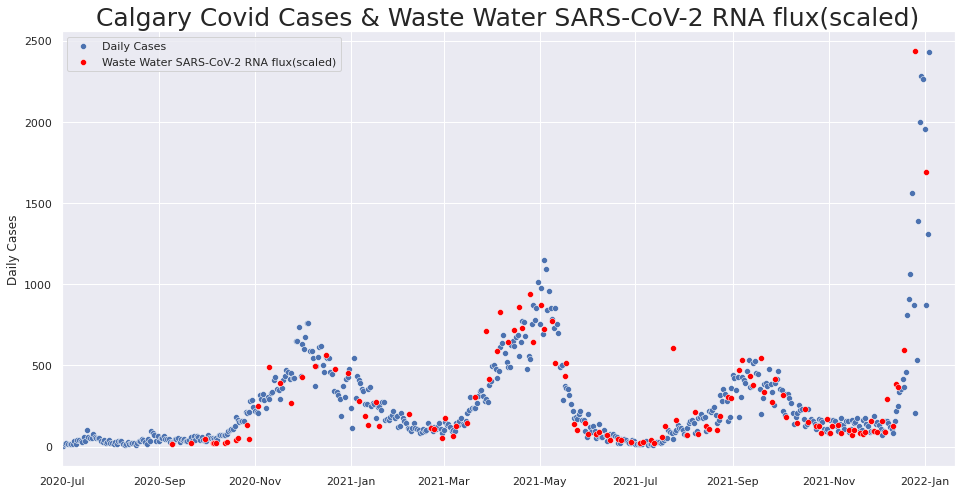

In [21]:
#Graph daily cases with 7 day moving average

sns.set(rc = {'figure.figsize':(16,8)})
#sns.set_style("whitegrid")
ax = sns.scatterplot(data = dly_cases_ww, x = 'Date', y = 'Cases')
#ax = sns.lineplot(data= dly_cases_ww, x = 'Date', y = '7MA', color = 'red')
ax = sns.scatterplot(data= dly_cases_ww, x = 'Date', y = ('ave_scale'), color = 'red')
#ax.set(yscale="log")


date_form = DateFormatter("%Y-%b")
ax.xaxis.set_major_formatter(date_form)
ax.set_title("Calgary Covid Cases & Waste Water SARS-CoV-2 RNA flux(scaled)", size = 25)
ax.legend(labels = ['Daily Cases', 'Waste Water SARS-CoV-2 RNA flux(scaled)'])
ax.set(xlabel="", ylabel="Daily Cases", 
      xlim = [pd.Timestamp('2020-07-01'), pd.Timestamp('2022-01-20')])
